In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from IPython.display import HTML
import scipy.stats as stats
from scipy import sparse
from time import time
from matplotlib.animation import FuncAnimation

This is the 2d advection equation,
$$
u_t+Au_x+Bu_y=0
$$
Let $t\in [0,T]$ and $x, y\in[0,1]$.
We now need to define some initial conditions,
$u(x,y,0)=f(x,y)$ where $f$ is a known function. We also need to assign values to $A,B$ for this we will use a vector field such that $$\Psi(x,y)=
\begin{pmatrix}
\frac{1}{2}-y\\ x-\frac{1}{2}
\end{pmatrix}$$
Now, we define these variables below.

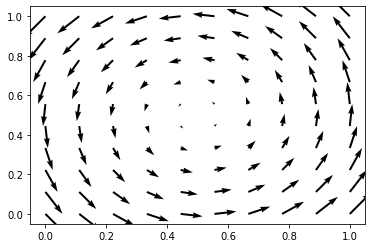

In [2]:
## Limits and step-sizes for each variable (all variables start from zero)
dx = 0.01
dy = 0.01
dt = 0.01
X = 1
Y = 1
T = 2*np.pi
Xs = int(X/dx)
Ys = int(Y/dy)
Ts = int(T/dt)+1

## Vector field
def psi(x, y):
    return 0.5-y, x-0.5

## Plot Vector field
x,y = np.meshgrid(np.linspace(0,1,10),np.linspace(0,1,10))
u = psi(x, y)[0]
v = psi(x, y)[1]
plt.quiver(x, y, u, v)

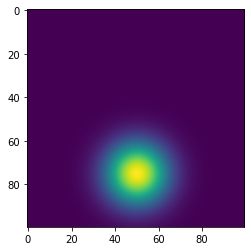

In [3]:
## Set up initial conditions
u = np.zeros((Xs, Ys, Ts))
x, y = np.mgrid[0:1:dx, 0:1:dy]
xy = np.column_stack([x.flat, y.flat])
mu = np.array([0.75,0.5])
sig = np.array([dx*10,dy*10])
cov = np.diag(sig**2)
u[:,:,0]=stats.multivariate_normal.pdf(xy, mean=mu, cov=cov).reshape(u[:,:,0].shape)/np.max(stats.multivariate_normal.pdf(xy, mean=mu, cov=cov))
plt.imshow(u[:,:,0])
ua=u

Following Leveque
pg 437

Firstly, we will try using a finite difference method. The method we will use is a 2d derivation of the Lax-Wendroff method which we saw earlier in the report. Firstly, we take the first three terms of the taylor expansion of $u$,
$$
u(i,j,n+1)=u+\Delta tu_t+\frac{1}{2}\Delta t^2u_{tt}+...
$$
For the sake of simplicity we have taken $u$ to mean $u(i,j,n)$ with similar notation for any partial derivatives. Now, we can use the 2d advection equation, $u_t=-Au_x-Bu_y$, and as for the $u_{tt}$ term we use the equation $\partial_t^ju=(-(A\partial_x+\partial_y))^ju$ which gives us,
$$
u_{tt}=A(Au_x)_x+A(Bu_y)_x+B(Au_x)_y+B(Bu_y)_y
$$
So, substituting these terms into the taylor series and gathering like terms gives us,
$$
u(i,j,n+1)=u-(\Delta tA+\frac{1}{2}\Delta t^2B)u_x-(\Delta tB+\frac{1}{2}\Delta t^2A)u_y+\Delta t^2ABu_{xy}+\frac{1}{2}\Delta t^2B^2u_{yy}+\frac{1}{2}\Delta t^2A^2u_{xx}
$$
Now, we employ the Lax-Wendroff method by replacing the partial derivatives with finite differences. We can use the exact same finite differences which we used to find the one-dimensional Lax-Wendroff scheme for all but one of the partial derivatives in the above equation. However, for the $u_{xy}$ term we use the formula,
$$
u_{xy}\approx\frac{1}{4\Delta x\Delta y}((U_{i+1,j+1}^n-U_{i-1,j+1}^n)-(U_{i+1,j-1}^n-U_{i-1,j-1}^n))
$$
Now, substituting in the finite differences we get,
$$
U_{i,j}^{n+1}=U_{i,j}^n-\frac{\Delta tA+\frac{1}{2}\Delta t^2B}{2\Delta x}(U_{i+1,j}^n-U_{i-1,j}^n)-\frac{\Delta tB-\frac{1}{2}\Delta t^2A}{2\Delta y}(U_{i,j+1}^n-U_{i,j-1}^n)+\frac{\Delta t^2AB}{4\Delta x\Delta y}((U_{i+1,j+1}^n-U_{i-1,j+1}^n)-(U_{i+1,j-1}^n-U_{i-1,j-1}^n))+\frac{\Delta t^2A^2}{\Delta x^2}(U_{i-1,j}^n-2U_{i,j}^n+U_{i+1,j}^n)+\frac{\Delta t^2B^2}{\Delta y^2}(U_{i,j-1}^n-2U_{i,j}^n+U_{i,j+1}^n)
$$
We implement the scheme below.

In [4]:
## Calculate Approximation
for n in range(Ts-1):
    for i in range(Xs):
        for j in range(Ys):
            ux          = (ua[(i+1)%100,j,n]-ua[i-1,j,n])/(2*dx)
            uy          = (ua[i,(j+1)%100,n]-ua[i,j-1,n])/(2*dy)
            uxy         = ((ua[(i+1)%100,(j+1)%100,n]-ua[i-1,(j+1)%100,n])-(ua[(i+1)%100,j-1,n]-ua[i-1,j-1,n]))/(4*dx*dy)
            uxx         = (ua[i-1,j,n]-2*ua[i,j,n]+ua[(i+1)%100,j,n])/(dy**2)
            uyy         = (ua[i,j-1,n]-2*ua[i,j,n]+ua[i,(j+1)%100,n])/(dx**2)
            B           = i*dx-0.5
            A           = j*dy-0.5
            ua[i,j,n+1] = ua[i,j,n]+(dt*A-dt*dt*B/2)*ux-(dt*B+dt*dt*A/2)*uy-dt*dt*B*A*uxy+dt*dt*B*B*uyy/2+dt*dt*A*A*uxx/2

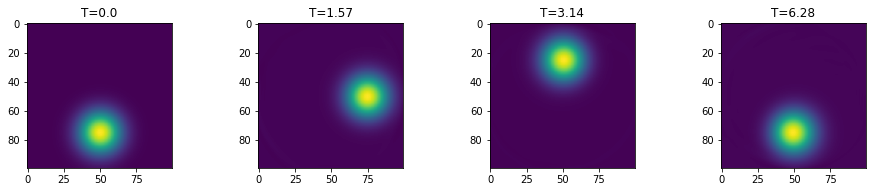

In [5]:
def js1(Ts):
    return [0,int(np.round(Ts/4, 0)),int(np.round(Ts/2, 0)),int(np.round(Ts-1, 0))]

## Plot graphs
maxi = np.max(ua[:,:,0])*1.1
fig, axs = plt.subplots(1, 4, figsize=(13,3))
fig.tight_layout()
fig.subplots_adjust(top=0.8)
#fig.suptitle("Lax-Wendroff Method", fontsize=16)
for ax, j in zip(axs, js1(Ts)):
    ax.set_title("T="+str(j*dt))
    ax.imshow(ua[:,:,j])

## Tophat Initial Conditions

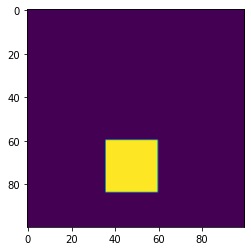

In [6]:
## Limits and step-sizes for each variable (all variables start from zero)
dx = 0.01
dy = 0.01
dt = 0.01
X = 1
Y = 1
T = 2*np.pi
Xs = int(X/dx)
Ys = int(Y/dy)
Ts = int(T/dt)+1

## Set up initial conditions
u = np.zeros((Xs, Ys, Ts))
p = int(Xs/8)
q = int(Ys/8)
for i in range(p*5, p*7):
    for j in range(q*3, q*5):
        u[i,j,0]=1

plt.imshow(u[:,:,0])
ub=u

In [7]:
## Calculate Approximation
for n in range(Ts-1):
    for i in range(Xs):
        for j in range(Ys):
            ux          = (ub[(i+1)%100,j,n]-ub[i-1,j,n])/(2*dx)
            uy          = (ub[i,(j+1)%100,n]-ub[i,j-1,n])/(2*dy)
            uxy         = ((ub[(i+1)%100,(j+1)%100,n]-ub[i-1,(j+1)%100,n])-(ub[(i+1)%100,j-1,n]-ub[i-1,j-1,n]))/(4*dx*dy)
            uxx         = (ub[i-1,j,n]-2*ub[i,j,n]+ub[(i+1)%100,j,n])/(dy**2)
            uyy         = (ub[i,j-1,n]-2*ub[i,j,n]+ub[i,(j+1)%100,n])/(dx**2)
            B           = i*dx-0.5
            A           = j*dy-0.5
            ub[i,j,n+1] = ub[i,j,n]+(dt*A-dt*dt*B/2)*ux-(dt*B+dt*dt*A/2)*uy-dt*dt*B*A*uxy+dt*dt*B*B*uyy/2+dt*dt*A*A*uxx/2

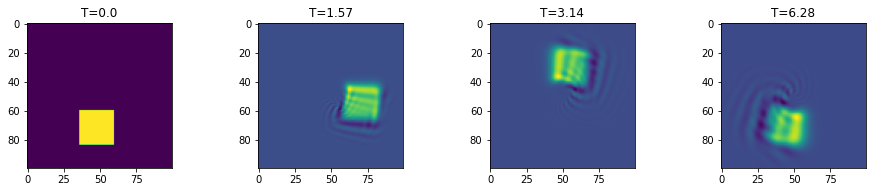

In [8]:
def js1(Ts):
    return [0,int(np.round(Ts/4, 0)),int(np.round(Ts/2, 0)),int(np.round(Ts-1, 0))]

## Plot graphs
maxi = np.max(ub[:,:,0])*1.1
fig, axs = plt.subplots(1, 4, figsize=(13,3))
fig.tight_layout()
fig.subplots_adjust(top=0.8)
#fig.suptitle("Lax-Wendroff Method", fontsize=16)
for ax, j in zip(axs, js1(Ts)):
    ax.set_title("T="+str(j*dt))
    ax.imshow(ub[:,:,j])